<h1>Import Data</h1>

In [1]:
import os
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import urllib
import IPython

In [2]:
import torch
from time import time


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
!unzip -q /content/gdrive/MyDrive/archive.zip

In [5]:
import pandas as pd
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

class CustomImageDataset(Dataset):
    def __init__(self, img_paths, mask_paths):
        self.img_paths = img_paths
        self.mask_paths = mask_paths

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        image = resize(imread(self.img_paths[idx]), (256, 256), mode='constant', anti_aliasing=True)
        mask = resize(imread(self.mask_paths[idx]), (256, 256), mode='constant', anti_aliasing=True) > 0.003
        image = np.array(image, np.float32)
        mask = np.array(mask, np.int32)
        return np.rollaxis(image, 2, 0), np.expand_dims(mask, axis=0)

In [6]:
def load_data(dataset_path):
    images = sorted(glob(os.path.join(dataset_path, "images/*")))
    masks = sorted(glob(os.path.join(dataset_path, "masks/*")))

    train_x, test_x = train_test_split(images, test_size=0.2, random_state=42)
    train_y, test_y = train_test_split(masks, test_size=0.2, random_state=42)

    return (train_x, train_y), (test_x, test_y)

In [7]:
import os

def load_datasets(root_dir, train_file, val_file):
    image_train = []
    image_val = []
    mask_train = []
    mask_val = []

    with open(os.path.join(root_dir, 'segmentation', train_file), 'r') as f:
        train_names = tuple(line.strip() for line in f.readlines())

    with open(os.path.join(root_dir, 'segmentation', val_file), 'r') as f:
        val_names = tuple(line.strip() for line in f.readlines())

    for root, dirs, files in os.walk(root_dir):
        if root.endswith('images'):
            for image in files:
                if image[:-4] in train_names:
                    image_train.append(os.path.join(root, image))
                else:
                    image_val.append(os.path.join(root, image))
        elif root.endswith('masks'):
            for image in files:
                if image[:-4] in train_names:
                    mask_train.append(os.path.join(root, image))
                else:
                    mask_val.append(os.path.join(root, image))

    image_train.sort()
    mask_train.sort()
    image_val.sort()
    mask_val.sort()

    return image_train, mask_train, image_val, mask_val


root = 'people_segmentation'
train_images, train_masks, val_images, val_masks = load_datasets(root, 'train.txt', 'val.txt')

train_dataset = CustomImageDataset(train_images, train_masks)
val_dataset = CustomImageDataset(val_images, val_masks)


In [8]:
batch_size = 16
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [9]:
def show_image(dataset, start_idx, end_idx):
    num_images = end_idx - start_idx + 1
    plt.figure(figsize=(18, 6))
    for i in range(num_images):
        plt.subplot(2, num_images, i+1)
        plt.axis("off")
        plt.imshow(np.rollaxis(dataset[start_idx + i][0], 0, 3))

        plt.subplot(2, num_images, num_images + i + 1)
        plt.axis("off")
        plt.imshow(np.rollaxis(dataset[start_idx + i][1], 0, 3))
    plt.show()



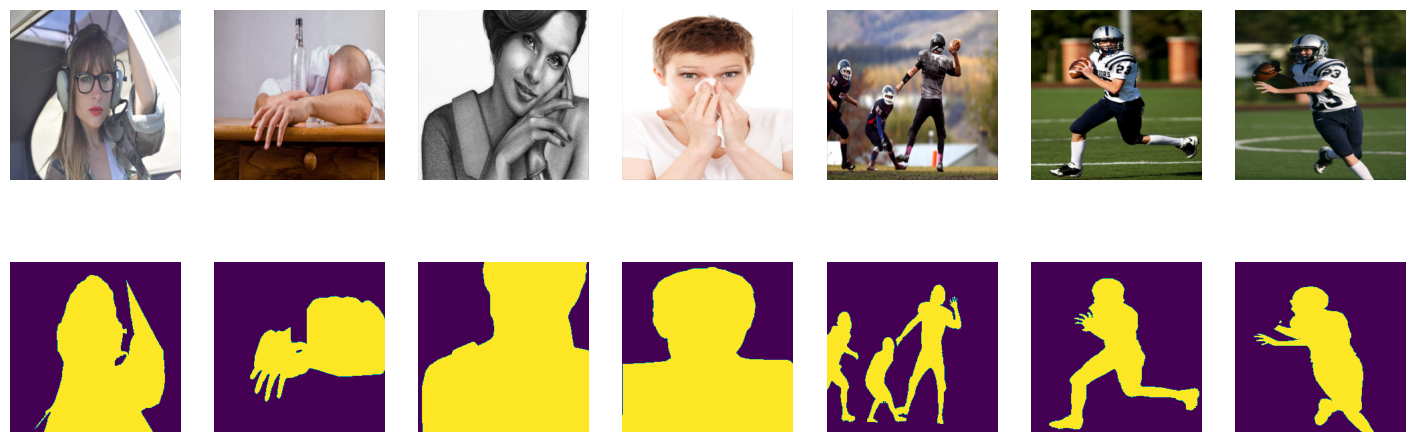

In [10]:
show_image(train_dataset, 20, 26)

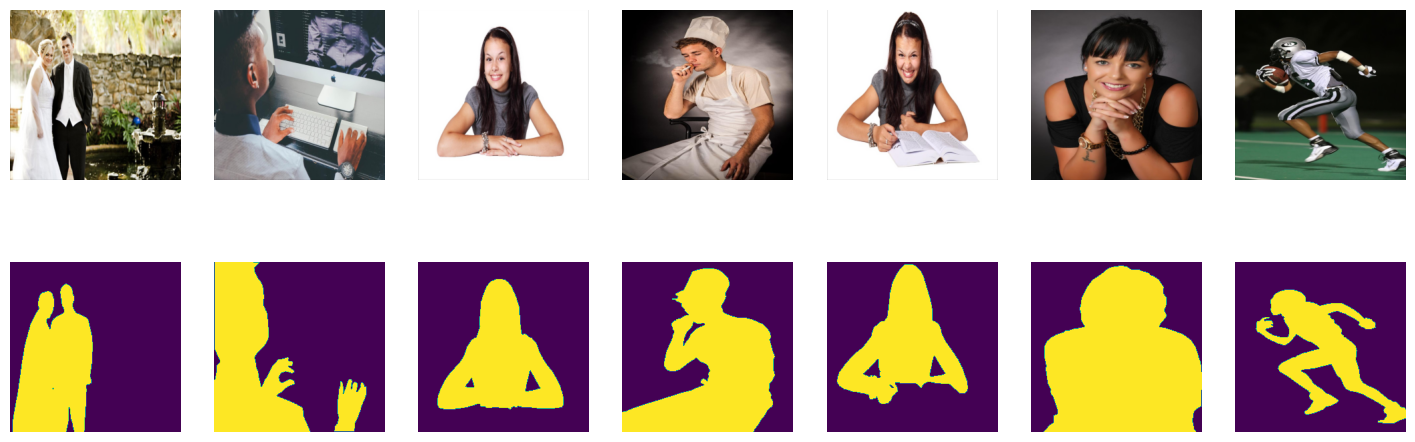

In [11]:
show_image(val_dataset, 20, 26)

In [12]:
import os
from glob import glob
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

<h1> Metric</h1>

In [13]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded

<h1> Loss Function</h1>

In [14]:
def bce_loss(y_real, y_pred):
    device = y_pred.device
    y_real = y_real.to(device)
    return (y_pred - (y_real * y_pred) + torch.log(1 + torch.exp(-y_pred))).sum()


<h1> Train logic </h1>

In [15]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from time import time
from IPython.display import clear_output
import os

def train(model, opt, loss_fn, epochs, data_tr, data_val, save_dir, model_name):
    X_val, Y_val = next(iter(data_val))
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()
            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()

        # show intermediate results
        model.eval()  # testing mode

        Y_hat = model(X_val.to(device)).detach().cpu()

        # Visualize tools
        #clear_output(wait=True)
        for k in range(4):
            plt.subplot(2, 4, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 4, k+5)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

        # Save model
        model_file = os.path.join(save_dir, 'model_epoch_%d_%s.pth' % (epoch+1, model_name))
        torch.save(model.state_dict(), model_file)
        print("Model saved at:", model_file)


<h1> Interference</h1>

In [16]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [model(X_batch) for X_batch, _ in data]
    return np.array(Y_pred)

In [17]:
def calculate_iou(predictions, targets):
    intersection = torch.logical_and(predictions, targets).sum()
    union = torch.logical_or(predictions, targets).sum()
    iou = intersection / union
    return iou.item()

def evaluate_unet(model, val_dataloader):
    model.eval()
    total_iou = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, targets in val_dataloader:
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)
            predictions = torch.sigmoid(outputs) > 0.5

            batch_iou = calculate_iou(predictions, targets)
            total_iou += batch_iou * images.size(0)
            total_samples += images.size(0)

    average_iou = total_iou / total_samples
    return average_iou

<h1> U-Net</h1>


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [19]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
                  nn.Conv2d(3, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(inplace=True),
                  nn.Conv2d(64, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(inplace=True))
        self.pool0 = nn.MaxPool2d(2)
        self.enc_conv1 = nn.Sequential(
                  nn.Conv2d(64, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU(inplace=True),
                  nn.Conv2d(128, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU(inplace=True))
        self.pool1 = nn.MaxPool2d(2)
        self.enc_conv2 = nn.Sequential(
                  nn.Conv2d(128, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)
        self.enc_conv3 = nn.Sequential(
                  nn.Conv2d(256, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU())
        self.pool3 = nn.MaxPool2d(2)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                  nn.Conv2d(512, 1024, kernel_size=3, padding=1),
                  nn.BatchNorm2d(1024),
                  nn.ReLU(),
                  nn.Conv2d(1024, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU())


        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)
        self.dec_conv0 = nn.Sequential(
                  nn.Conv2d(1024, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU())
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.dec_conv1 = nn.Sequential(
                  nn.Conv2d(512, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU())
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.dec_conv2 = nn.Sequential(
                  nn.Conv2d(256, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU(),
                  nn.Conv2d(128, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU())
        self.upsample3 = nn.Upsample(scale_factor=2)
        self.dec_conv3 = nn.Sequential(
                  nn.Conv2d(128, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, 1, kernel_size=1))

    def forward(self, x):

        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.pool3(self.bottleneck_conv(e3))

        #decoder
        d0 = self.dec_conv0(torch.cat([e3, self.upsample0(b)], dim=1))
        d1 = self.dec_conv1(torch.cat([e2, self.upsample1(d0)], dim=1))
        d2 = self.dec_conv2(torch.cat([e1, self.upsample2(d1)], dim=1))
        d3 = self.dec_conv3(torch.cat([e0, self.upsample3(d2)], dim=1))
        return d3

<h1> Learning</h1>

In [ ]:
len(train_loader)

320

In [ ]:
len(val_loader)

36

In [30]:
model_unet = UNet().to(device)


# Завантаження збережених параметрів моделі
model_path_old = "/content/gdrive/MyDrive/model_epoch_15_unet.pth"
model_unet.load_state_dict(torch.load(model_path_old))

model_path_new = '/content/gdrive/MyDrive/ColabNotebooks/'

* Epoch 1/20


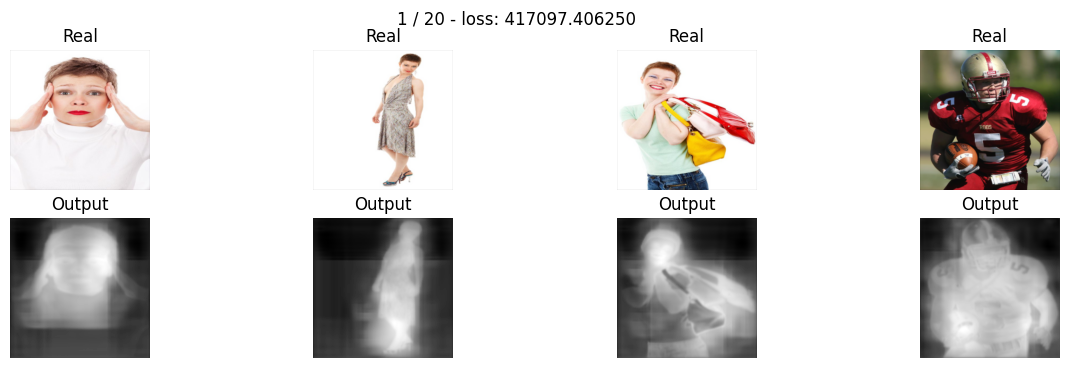

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_1_unet.pth
* Epoch 2/20


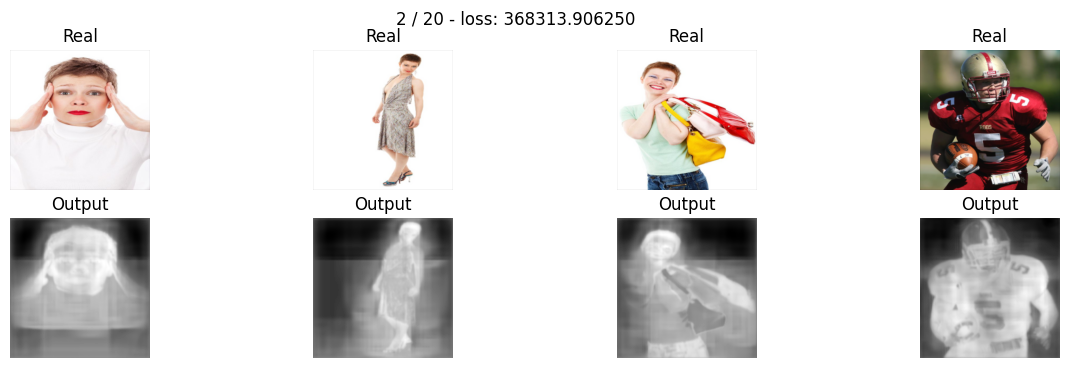

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_2_unet.pth
* Epoch 3/20


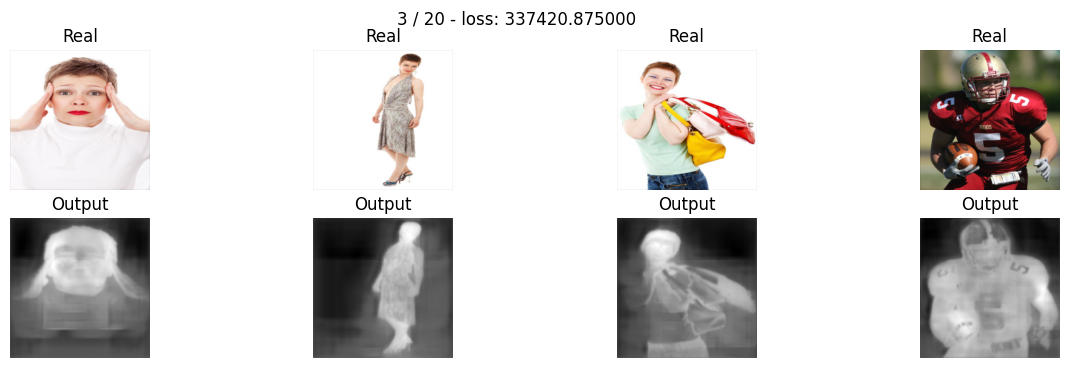

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_3_unet.pth
* Epoch 4/20


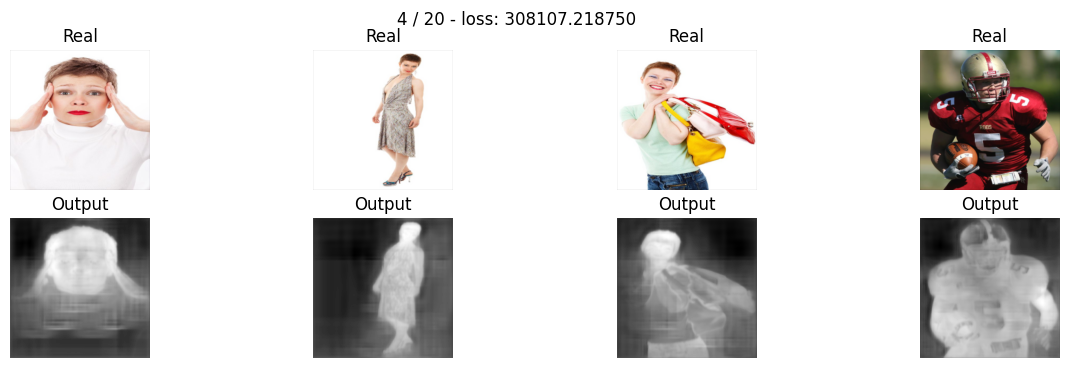

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_4_unet.pth
* Epoch 5/20


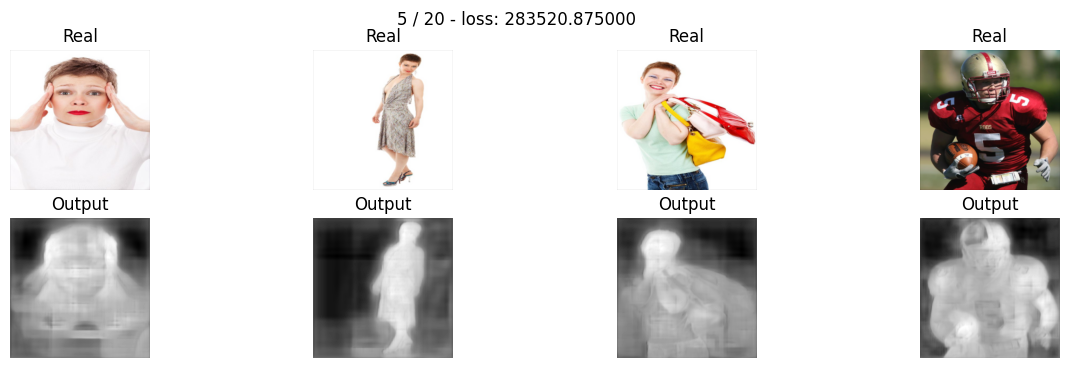

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_5_unet.pth
* Epoch 6/20


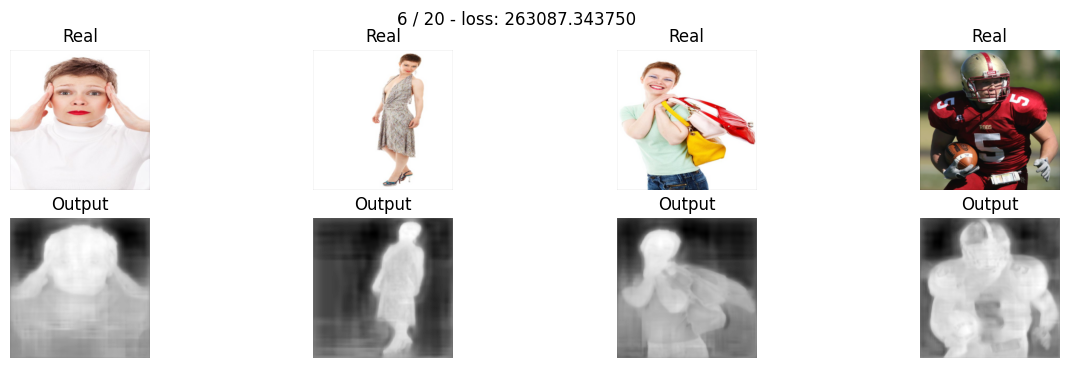

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_6_unet.pth
* Epoch 7/20


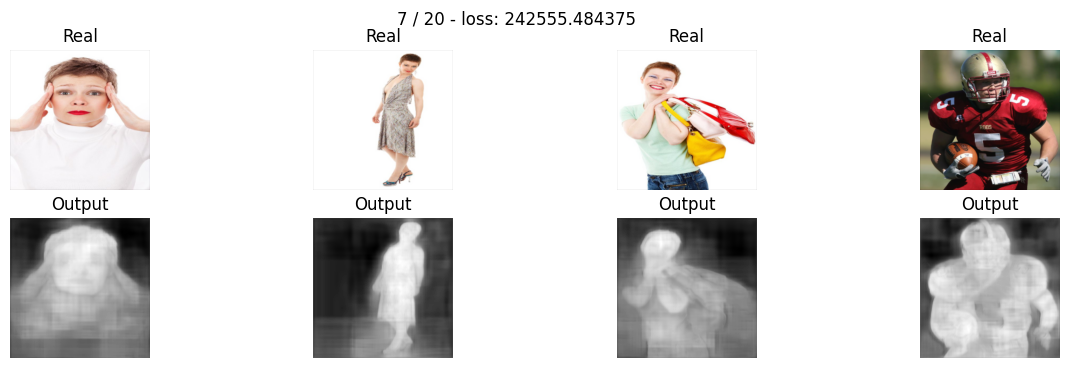

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_7_unet.pth
* Epoch 8/20


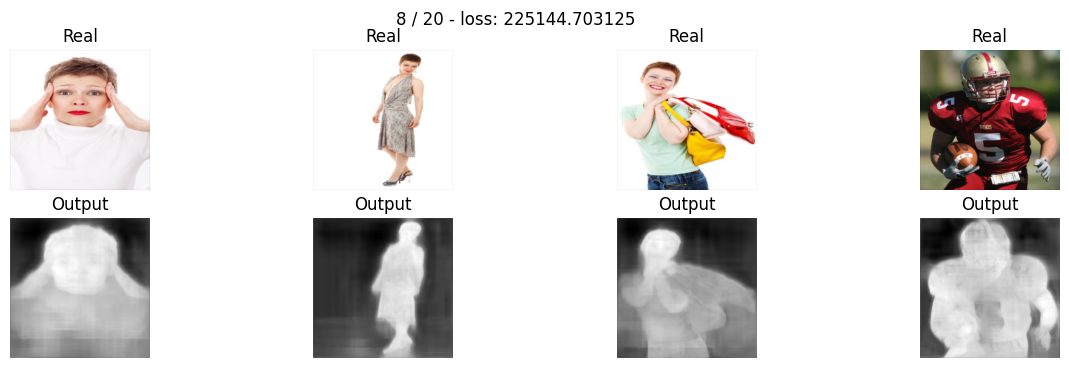

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_8_unet.pth
* Epoch 9/20


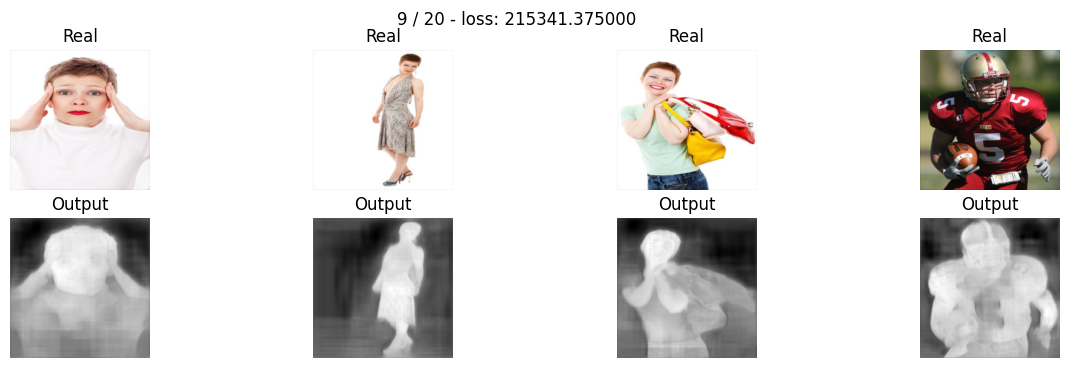

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_9_unet.pth
* Epoch 10/20


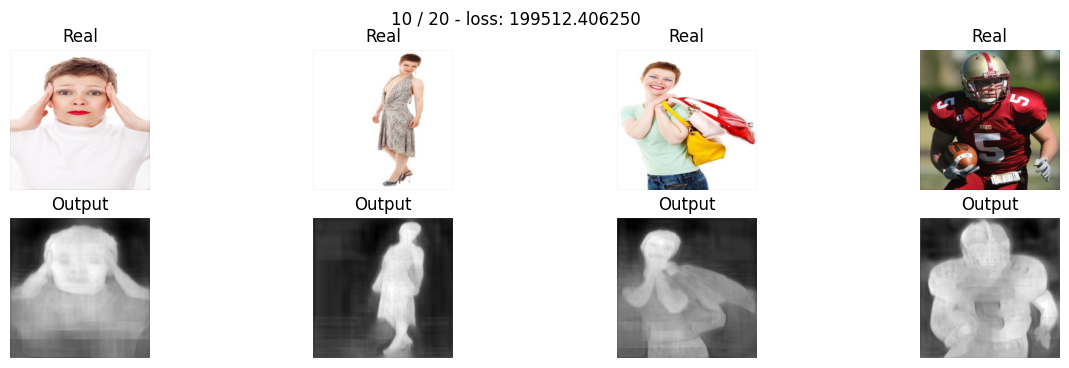

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_10_unet.pth
* Epoch 11/20


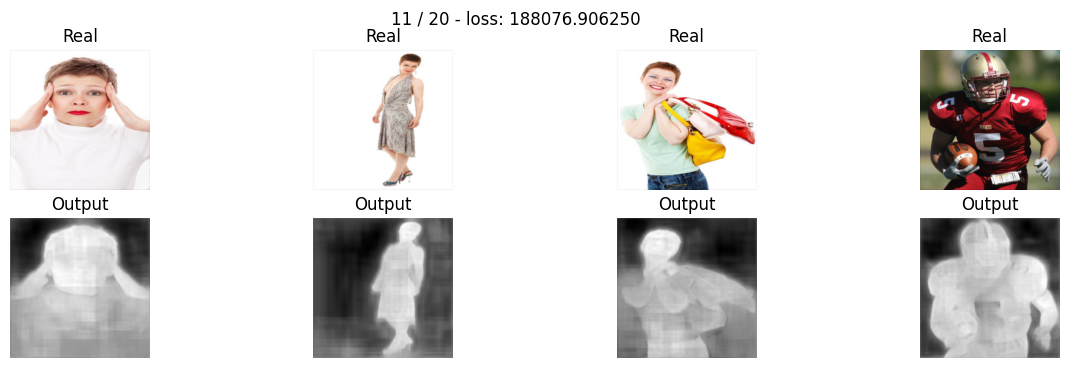

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_11_unet.pth
* Epoch 12/20


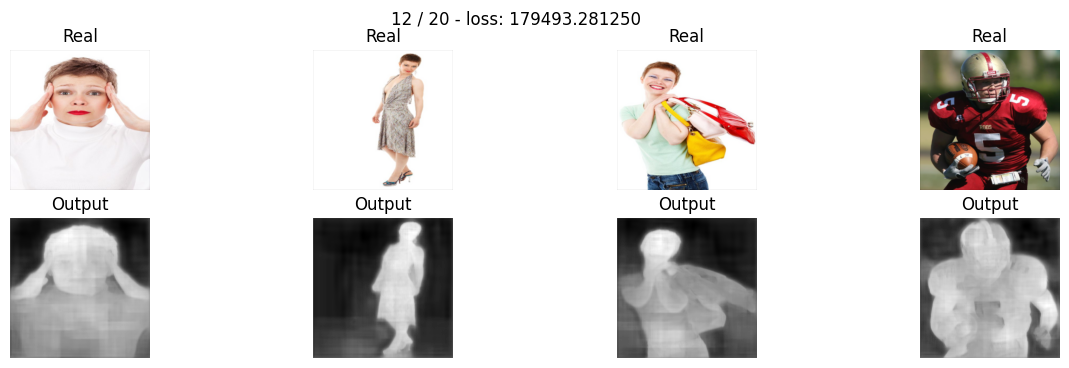

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_12_unet.pth
* Epoch 13/20


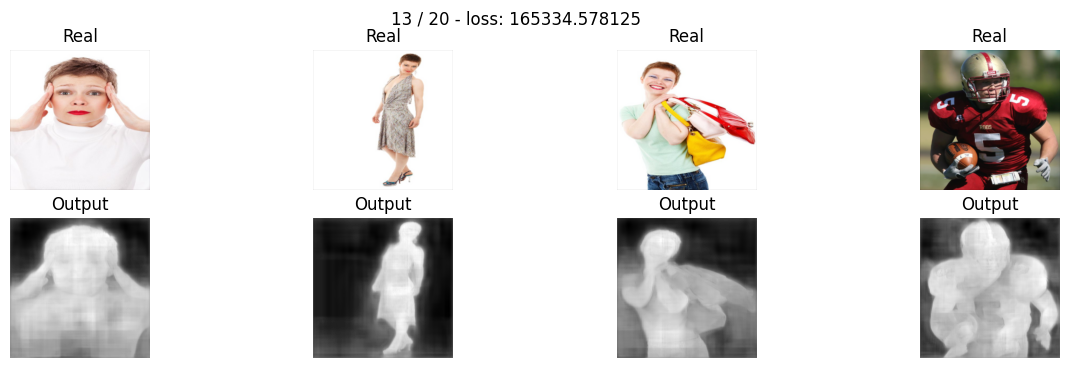

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_13_unet.pth
* Epoch 14/20


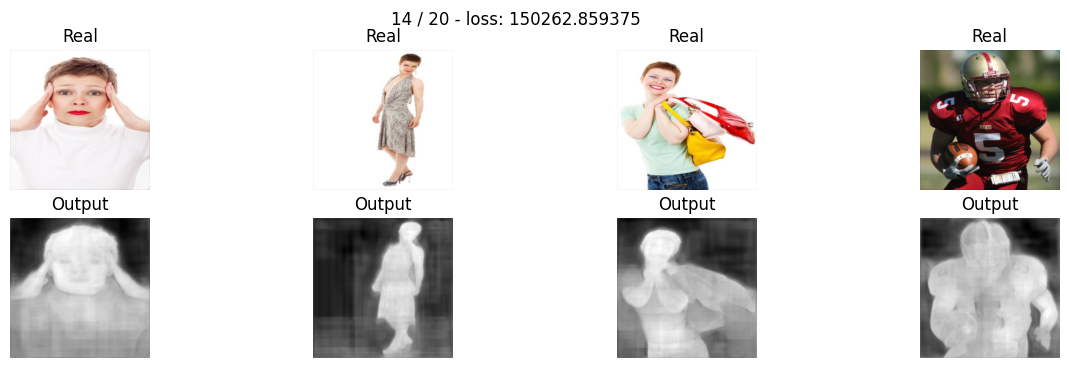

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_14_unet.pth
* Epoch 15/20


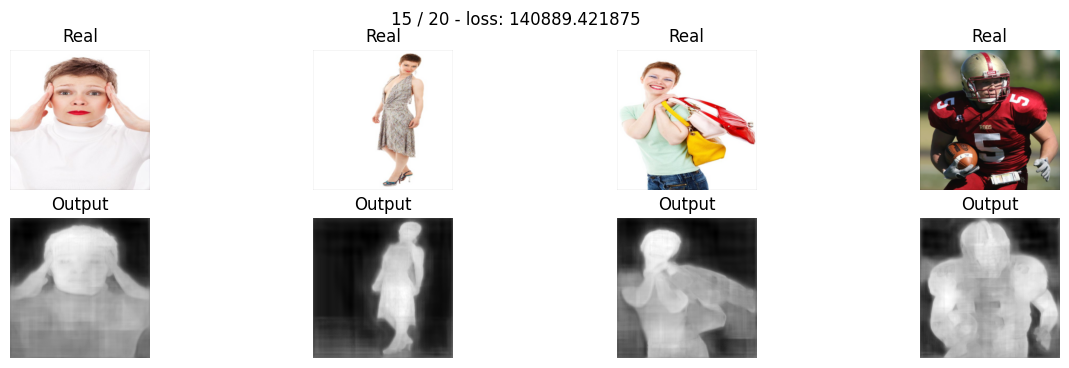

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_15_unet.pth
* Epoch 16/20


In [ ]:
max_epochs = 20
optimize = torch.optim.Adam(model_unet.parameters())
train(model_unet, optimize, bce_loss, max_epochs, train_loader, val_loader,model_path_new,'unet' )

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
evaluate_unet(model, val_loader)

0.7133468406301149

U-net показує дуже гарні результати після 35 епох (на іншому акаунті зробив 20, закінчилися ресурси і продовжив тут)

<h1>SegNET<h1>

In [21]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
                  nn.Conv2d(3, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU())
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv1 = nn.Sequential(
                  nn.Conv2d(64, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU(),
                  nn.Conv2d(128, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU())
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv2 = nn.Sequential(
                  nn.Conv2d(128, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU())
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv3 = nn.Sequential(
                  nn.Conv2d(256, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU())
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)


        # decoder (upsampling)
        self.upsample1 =  nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(
                  nn.Conv2d(512, 512, 3, 1, 1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, 3, 1, 1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 256, 3, 1, 1),
                  nn.BatchNorm2d(256),
                  nn.ReLU())
        self.upsample2 =  nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(
                  nn.Conv2d(256, 256, 3, 1, 1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 256, 3, 1, 1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 128, 3, 1, 1),
                  nn.BatchNorm2d(128),
                  nn.ReLU())
        self.upsample3 =  nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv3 = nn.Sequential(
                  nn.Conv2d(128, 128, 3, 1, 1),
                  nn.BatchNorm2d(128),
                  nn.ReLU(),
                  nn.Conv2d(128, 64, 3, 1, 1),
                  nn.BatchNorm2d(64),
                  nn.ReLU())
        self.upsample4 =  nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv4 = nn.Sequential(
                  nn.Conv2d(64, 64, 3, 1, 1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, 1, 3, 1, 1))

    def forward(self, x):

        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))


        # decoder
        d1 = self.dec_conv1(self.upsample1(e3,ind3))
        d2 = self.dec_conv2(self.upsample2(d1,ind2))
        d3 = self.dec_conv3(self.upsample3(d2,ind1))
        d4 = self.dec_conv4(self.upsample4(d3,ind0))
        return d4

In [22]:
batch_size = 4
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [25]:
model_seg = SegNet().to(device)


# Завантаження збережених параметрів моделі
model_path_old = "/content/gdrive/MyDrive/model_epoch_13_segnet.pth"
model_seg.load_state_dict(torch.load(model_path_old))

model_path_new = '/content/gdrive/MyDrive/ColabNotebooks/'

* Epoch 1/20


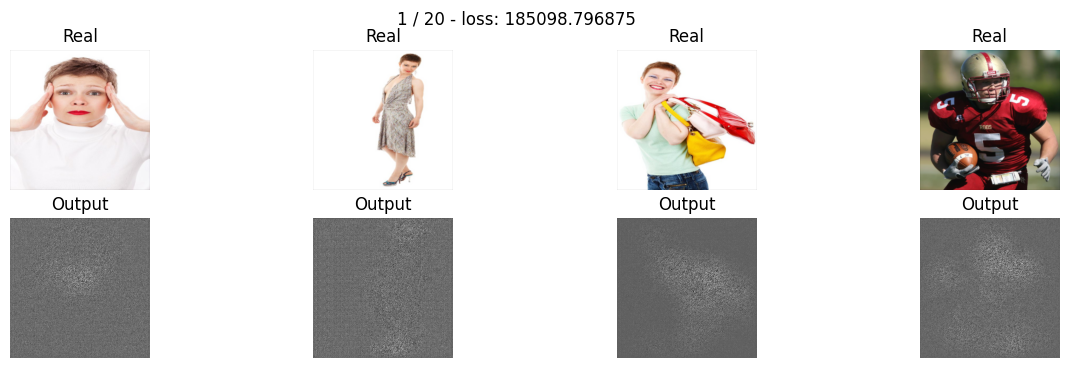

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_1_segnet.pth
* Epoch 2/20


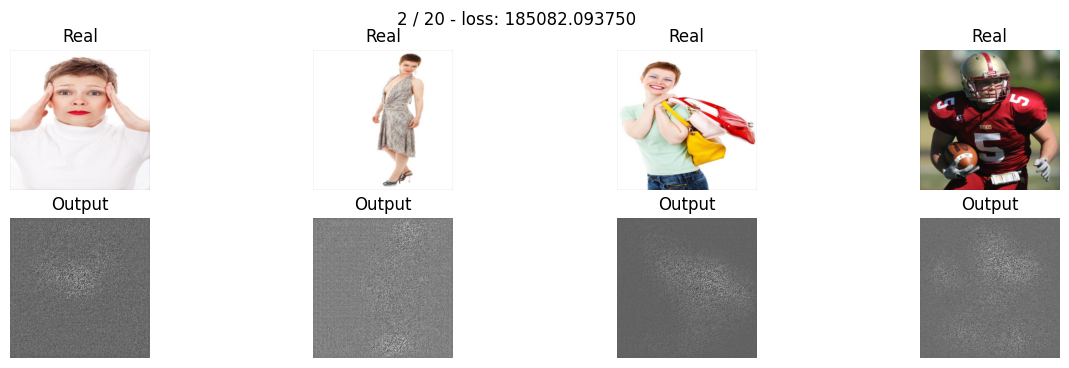

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_2_segnet.pth
* Epoch 3/20


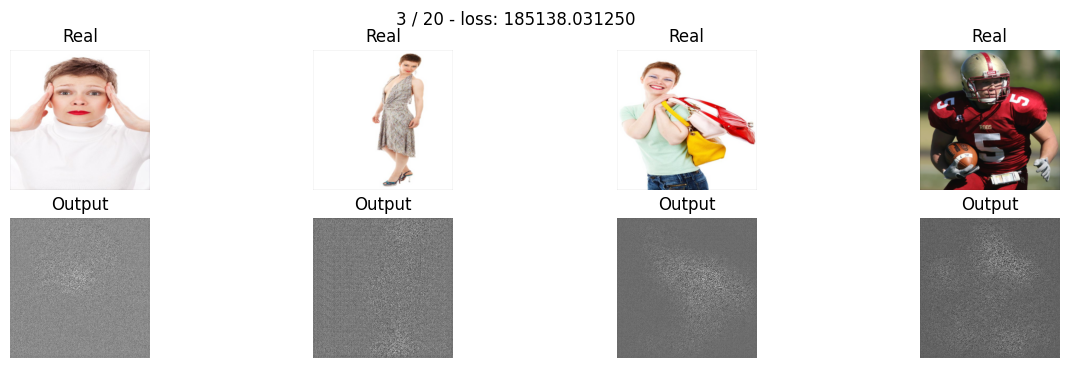

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_3_segnet.pth
* Epoch 4/20


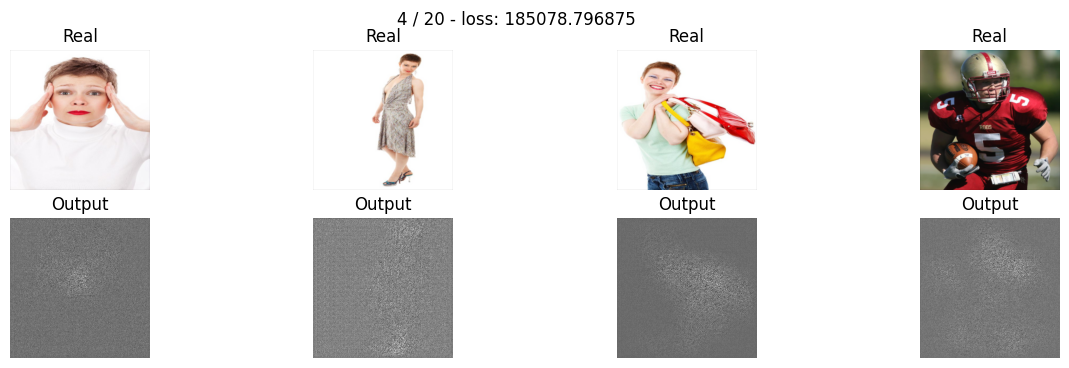

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_4_segnet.pth
* Epoch 5/20


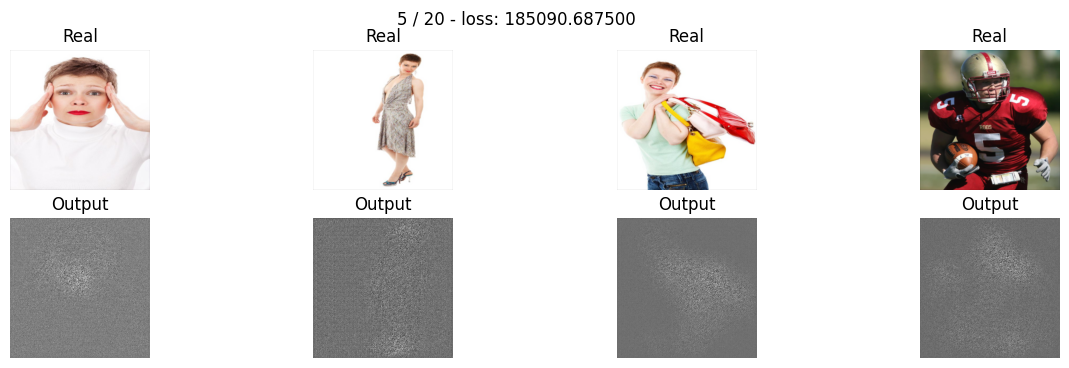

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_5_segnet.pth
* Epoch 6/20


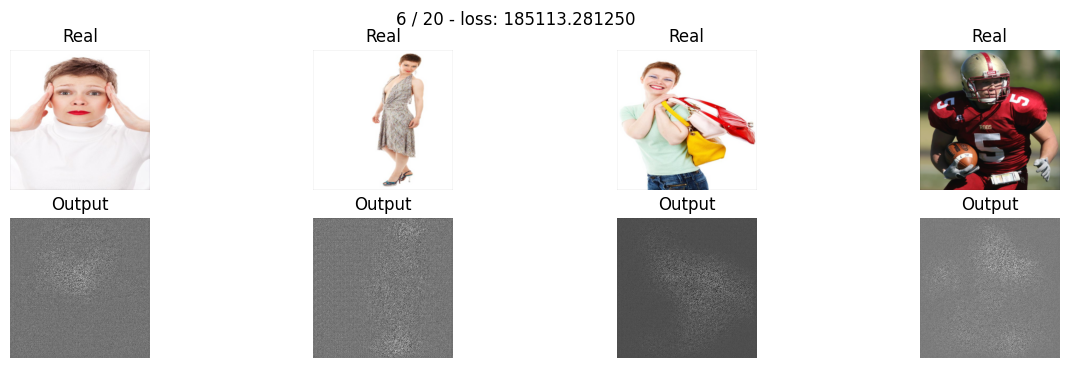

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_6_segnet.pth
* Epoch 7/20


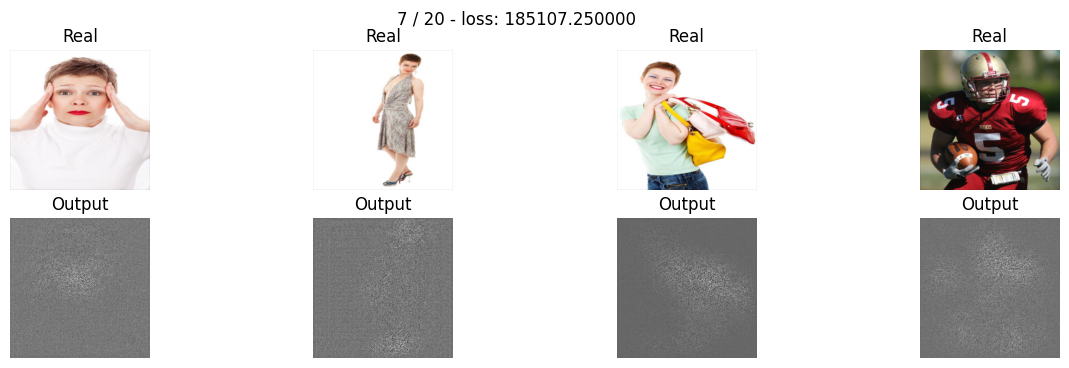

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_7_segnet.pth
* Epoch 8/20


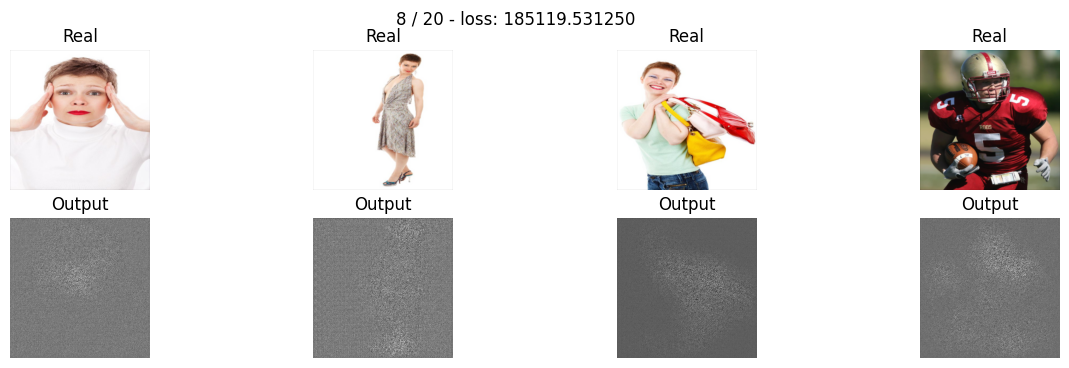

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_8_segnet.pth
* Epoch 9/20


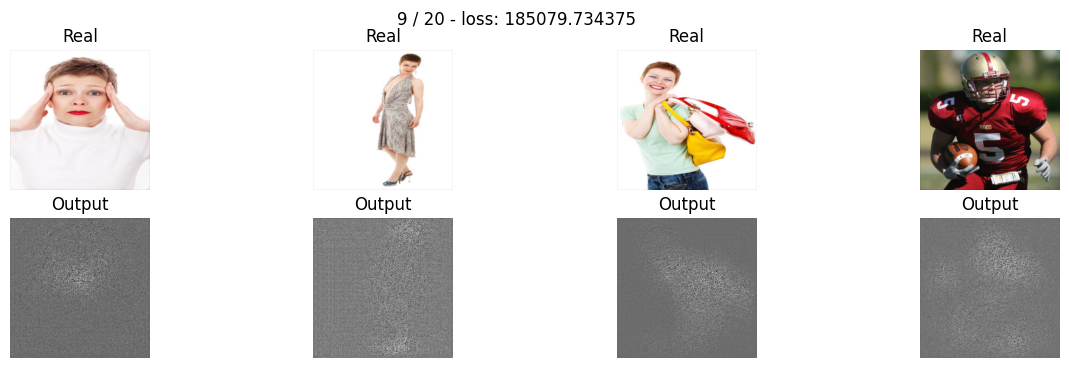

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_9_segnet.pth
* Epoch 10/20


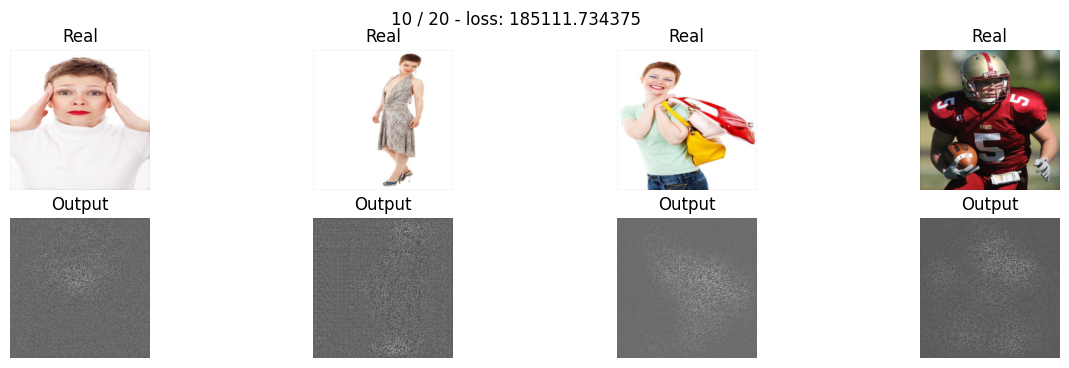

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_10_segnet.pth
* Epoch 11/20


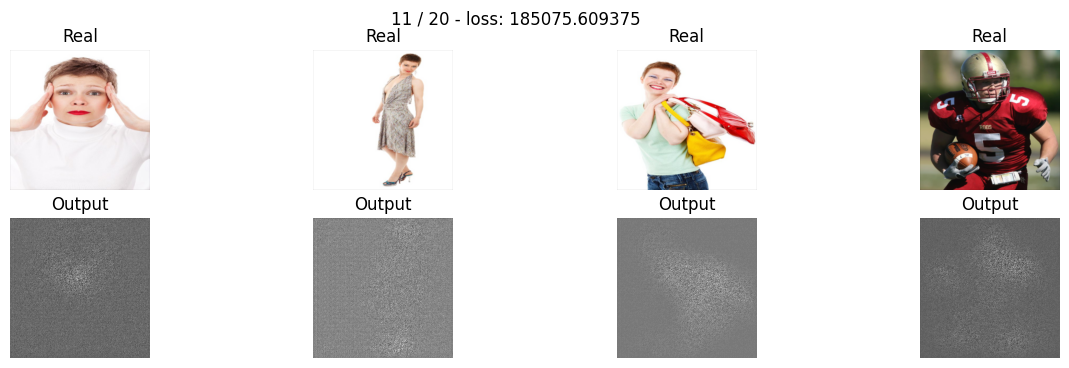

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_11_segnet.pth
* Epoch 12/20


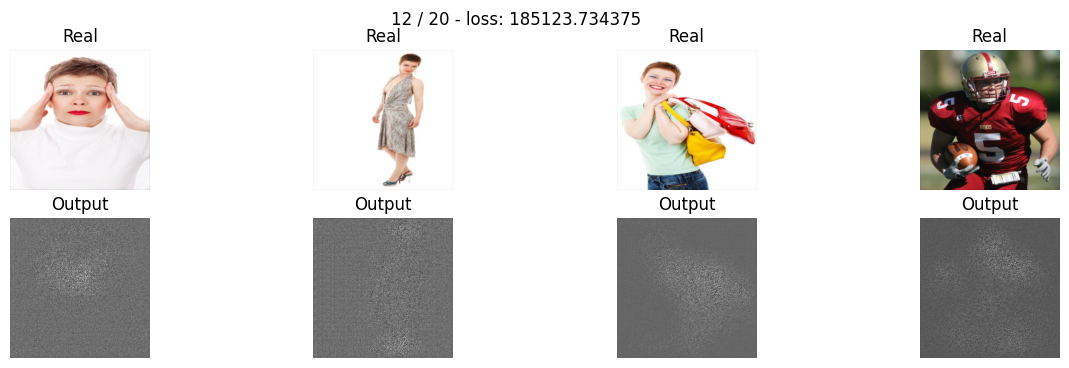

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_12_segnet.pth
* Epoch 13/20


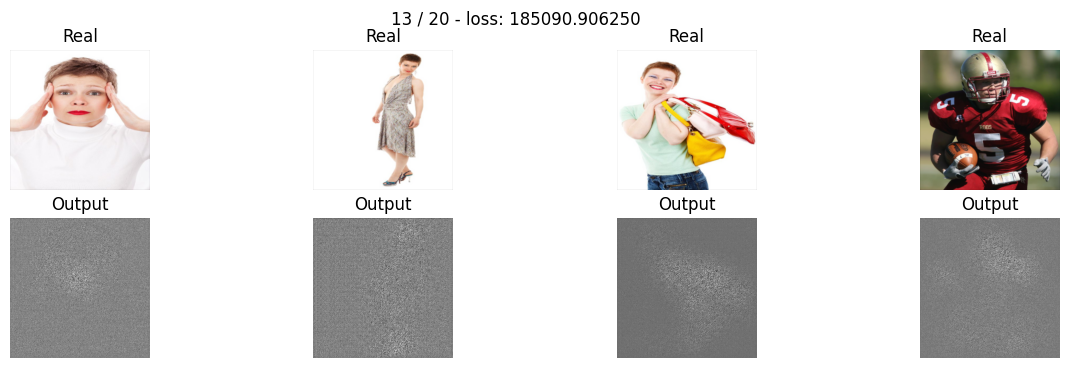

Model saved at: /content/gdrive/MyDrive/ColabNotebooks/model_epoch_13_segnet.pth
* Epoch 14/20


In [ ]:
max_epochs = 20
optimize = torch.optim.Adam(model.parameters())
train(model_seg, optimize, bce_loss, max_epochs, train_loader, val_loader,model_path_new,'segnet' )

In [26]:
evaluate_unet(model_seg, val_loader)

0.21118961203790887

SetNet була натренерована на 13 епохах, і показала результат 0.21, на жаль, вже використані всі мої акаунти, тож збільшити результат не зможу

<h1> Test </h1>

In [45]:
def test_model(model, image_path):

    # Завантаження зображення та зміна його розміру
    image = resize(imread(image_path), (256, 256), mode='constant', anti_aliasing=True)
    image = np.array(image, np.float32)
    image = np.rollaxis(image, 2, 0)

    # Передбачення за допомогою моделі
    result = model(torch.from_numpy(image).unsqueeze(0).to(device)).squeeze(0).detach().cpu()
    result_mask = result > 0.5

    # Застосування маски до оригінального зображення
    image_without_bg = np.rollaxis(image * result_mask.numpy(), 0, 3)

    # Відображення результатів
    plt.figure(figsize=(18, 6))

    # Оригінальне зображення
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plt.imshow(np.rollaxis(image, 0, 3))
    plt.title('Original Image')

    # Відображення маски
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(result_mask.squeeze(), cmap='gray')
    plt.title('Predicted Mask')

    # Зображення без фону
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.imshow(image_without_bg)
    plt.title('Image without Background')

    plt.show()


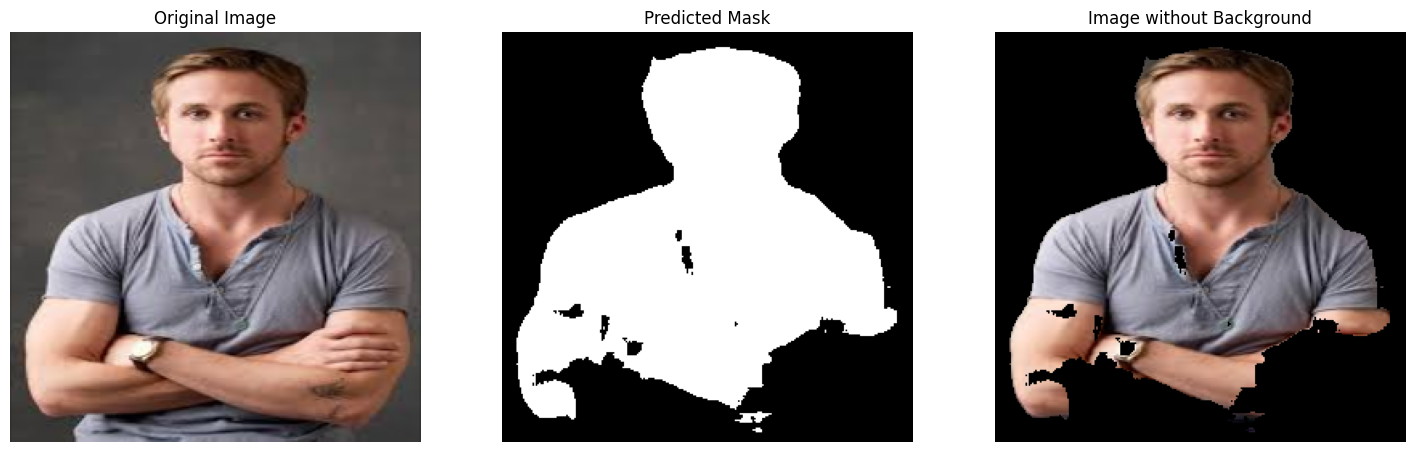

In [48]:
test_model(model_unet, '/content/gdrive/MyDrive/images.jpg' )

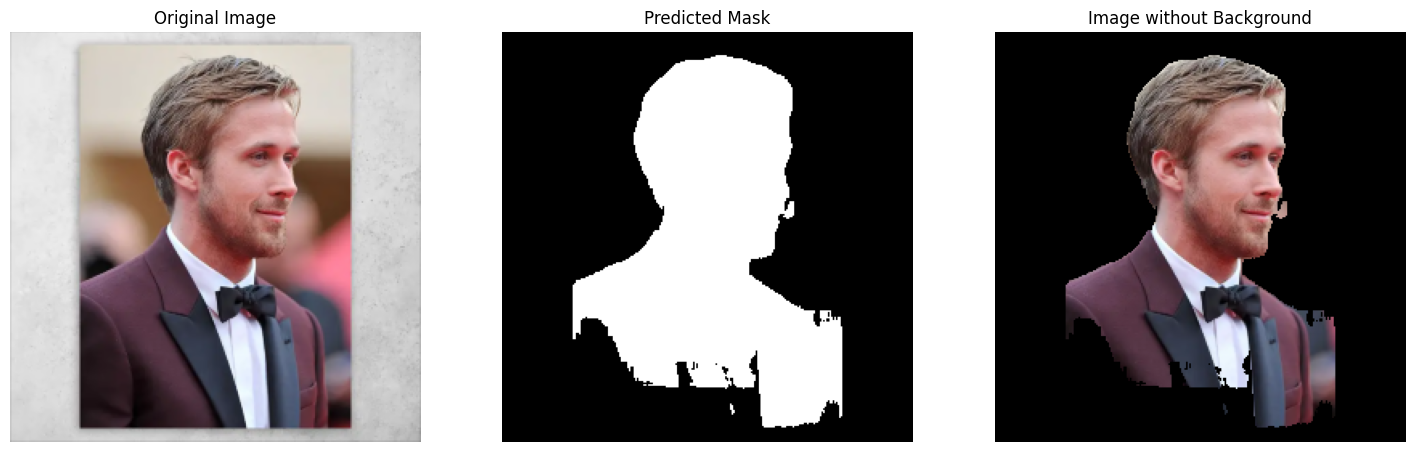

In [49]:
test_model(model_unet, '/content/gdrive/MyDrive/5566953361_w600_h600_5566953361.webp' )

Unet (36 епох):
*   IoU: 0.71

Unet дуже важка модель, її архітекрута більш сучасна, тож всі ресурси витратив саме на неї. Завдяки цьому вийшов гарний результат


SegNet (13 епох):
*   IoU: 0.21

Робив SegNet для порівняння з Unet, але ресурсів GoogleColab на SegNet вже не вистачало, тож не тренував більше ніж 13 епох, через це й вишла низька точність, як би мав ще акаунти, то була би вище, як мені здається нічим не гірше ніж в Unet

Загалом, як бачимо з тестів, з Unet теж ще є проблеми, але я думаю їх можна виправити постпроцесінгом(агрегація чи thresholding)
